# Practical task sheet 04 -- quality analysis and prediction
The fourth task sheet will cover topics related to quality, analysis of features, and quality prediction.
Within this task sheet, the focus will be parametric functions.

To prepare for the tasks the following material should be checked out:

* [subjective testing](https://en.wikipedia.org/wiki/Subjective_video_quality)
* [pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
* [ITU-T P.1203.2](https://www.itu.int/rec/T-REC-P.1203.2-201710-I/en)
* [Hoßfeld 2011- SOS: The MOS is not enough!](https://www.researchgate.net/publication/220773357_SOS_The_MOS_is_not_enough)
* [ITU-T Recommendation P.1401 (Appendix III)](https://www.itu.int/rec/T-REC-P.1401-202001-I/en)
* [ITU-T Rec. P.913](https://www.itu.int/rec/T-REC-P.913-202106-I/en)
* [AVT-VQDB-UHD-1](https://www.researchgate.net/publication/338201010_AVT-VQDB-UHD-1_A_Large_Scale_Video_Quality_Database_for_UHD-1)

The idea is, that you learn some practical basic data analysis approaches, learn to invest data, train simple models and evaluate such models.
The overall journey starts with:
* subjective testing 
* feature development and analysis
* models, models, and models.



**General Hint**: in each code cell the parts where code needs to be added is marked with TBD, prefer simple code than complicated.
It is further not a problem if you cannot solve all tasks.

In [1]:
# version 2

In [2]:
# install requirements (this cell should not produce any errors, otherwise check dependencies and guide)
!pip3 install --user numpy pandas matplotlib scipy jupyter scikit-image scikit-learn scikit-video

In [3]:
# helper functions
import os
import platform
import shutil 
import urllib.request
import glob
import subprocess
import json


# enables inline plots
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib

import numpy as np

from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_predict
# change to "from sklearn.cross_validation import cross_val_predict" if import errors occur


import pandas as pd
from pandas.plotting import scatter_matrix

from IPython.display import display as d  # display nice tables in jupyter

import skimage.io
import numpy as np


def savefig(filename):
    """saves a figure as file """
    plt.savefig(filename, bbox_inches="tight")

def heat_map(df):
    """shows a simple heat map"""
    plt.imshow(df, cmap="YlGnBu")
    plt.colorbar()
    plt.xticks(range(len(df)),df.columns, rotation=20)
    plt.yticks(range(len(df)),df.index)
    plt.show()


def shell_call(call):
    """
    Run a program via system call and return stdout + stderr.
    `call` is a command line string, similar to the command you would type inside your terminal, 
        e.g. under linux call="ls -la /"
    returns stdout and stderr of the called program
    """
    try:
        output = subprocess.check_output(call, universal_newlines=True, shell=True)
    except Exception as e:
        output = str(e.output)
    return output


# ffmepg & ffprobe specific

def _get_file(url, target_filename_and_path):
    """
    downloads a file from `url` to `target_filename_and_path`
    """
    if os.path.isfile(target_filename_and_path):
        # prevent of downloading several times
        return True
    try:
        urllib.request.urlretrieve(url, target_filename_and_path)
    except urllib.error.URLError as e:
        return False
    return True

def download_local_ffmpeg_ffprobe():
    """ will download binaries for ffprobe to tools directory """
    print("download local installed ffmpeg and ffprobe for your OS, download will take some time")
    os.makedirs("tools", exist_ok=True)

    ffprobe_links = {
        "win": {
            "link": "https://cloud.tu-ilmenau.de/s/S4ZR97kdpgCS7pD/download",
            "exe": os.path.join("tools", "ffprobe.exe")
        },
        "macos": {
            "link": "https://cloud.tu-ilmenau.de/s/XgT4NWjqNrtjkNK/download",
            "exe": os.path.join("tools", "ffprobe")
        },
        "linux": {
            "link": "https://cloud.tu-ilmenau.de/s/sT23KSsD3XRw9yb/download",
            "exe": os.path.join("tools", "ffprobe")
        }
    }
    ffmpeg_links = {
        "win": {
            "link": "https://cloud.tu-ilmenau.de/s/dnWb9nkp4t3TRx6/download",
            "exe": os.path.join("tools", "ffmpeg.exe")
        },
        "macos": {
            "link": "https://cloud.tu-ilmenau.de/s/QxYxgpqo8DtzQDk/download",
            "exe": os.path.join("tools", "ffmpeg")
        },
        "linux": {
            "link": "https://cloud.tu-ilmenau.de/s/f2nFkomjNQecScr/download",
            "exe": os.path.join("tools", "ffmpeg")
        }
    }

    ffprobe = shutil.which("ffprobe") # system version as fallback, not sure if this works for Windows
    ffmpeg = shutil.which("ffmpeg")

    make_executable = False
    os_name = "default"
    os_mapping = {
        "Windows": "win",
        "Darwin": "macos",
        "Linux": "linux"
    }
    if platform.system() in os_mapping:
        os_name = os_mapping[platform.system()]

    if os_name in ffprobe_links:
        tmp = _get_file(ffprobe_links[os_name]["link"], ffprobe_links[os_name]["exe"])
        ffprobe = ffprobe_links[os_name]["exe"]

    if os_name in ffmpeg_links:
        tmp = _get_file(ffmpeg_links[os_name]["link"], ffmpeg_links[os_name]["exe"])
        ffmpeg = ffmpeg_links[os_name]["exe"]

    if os_name in ["linux", "macos"]:
        os.system(f"chmod +x {ffprobe}")  # not sure if this works for MACOS, or is even required
        os.system(f"chmod +x {ffmpeg}")

    print(f"ffmpeg executable used {ffmpeg}")
    print(f"ffprobe executable used {ffprobe}")
    return ffmpeg, ffprobe

ffmpeg, ffprobe = download_local_ffmpeg_ffprobe()
# end of ffmepg & ffprobe specific

download local installed ffmpeg and ffprobe for your OS, download will take some time
ffmpeg executable used tools\ffmpeg.exe
ffprobe executable used tools\ffprobe.exe


## Subtask 1: Analysis of subjective test data
The basis for quality predictions usually is formed by conducted subjective tests. In such a subjective test, that is either performed inside a lab test room with some specifications or e.g. a crowd based test, participants are asked to rate the quality of several shown stimuli.


In the following ratings from a subjective video quality test that have been collected are provided as a file `ratings.csv`, that we will further check in the following cells.

The provided subjective scores are part of the [AVT-VQDB-UHD-1](https://github.com/Telecommunication-Telemedia-Assessment/AVT-VQDB-UHD-1), an overview about the conducted tests is given in the [paper](https://www.researchgate.net/publication/338201010_AVT-VQDB-UHD-1_A_Large_Scale_Video_Quality_Database_for_UHD-1), moreover the videos are also accessible.

In [4]:
# read `test_1_per_user.csv` file with pandas
 
raw_ratings = pd.read_csv('test_1_per_user.csv')  # TBD
d(raw_ratings.head())

# create list of all `user_colums`
user_cols = (raw_ratings.columns).drop('video_name')   # TBD

   
# investigate some general information about the data

# how many users:
number_of_users =  len(user_cols)   # TBD

# how many uniqe stimuli
numer_of_stimuli = len(raw_ratings.index )  # TBD

print(f"{number_of_users} participants")
print(f"{numer_of_stimuli} rated stimuli")

,video_name,user1,user2,user3,user4,user5,user6,user7,user8,user9,...,user20,user21,user22,user23,user24,user25,user26,user27,user28,user29
0,american_football_harmonic_200kbps_360p_59.94f...,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,american_football_harmonic_750kbps_360p_59.94f...,2,4,3,2,2,2,4,2,2,...,2,2,2,3,1,2,1,2,1,3
2,american_football_harmonic_750kbps_720p_59.94f...,2,3,1,1,2,1,2,2,1,...,1,2,2,2,1,2,1,2,1,2
3,american_football_harmonic_2000kbps_720p_59.94...,3,4,4,2,3,3,4,3,3,...,5,2,3,4,2,3,2,3,2,3
4,american_football_harmonic_2000kbps_1080p_59.9...,2,4,3,2,2,2,3,2,2,...,3,2,3,3,1,2,2,2,2,2


29 participants
180 rated stimuli


### Subtask 1.1: User ratings
In the following part, we will check the ratings of individual users in detail.
Such an analysis is required, to e.g. remove outliers (that are users who did not rated "properly").

user:7 and user:16 are not so trustable


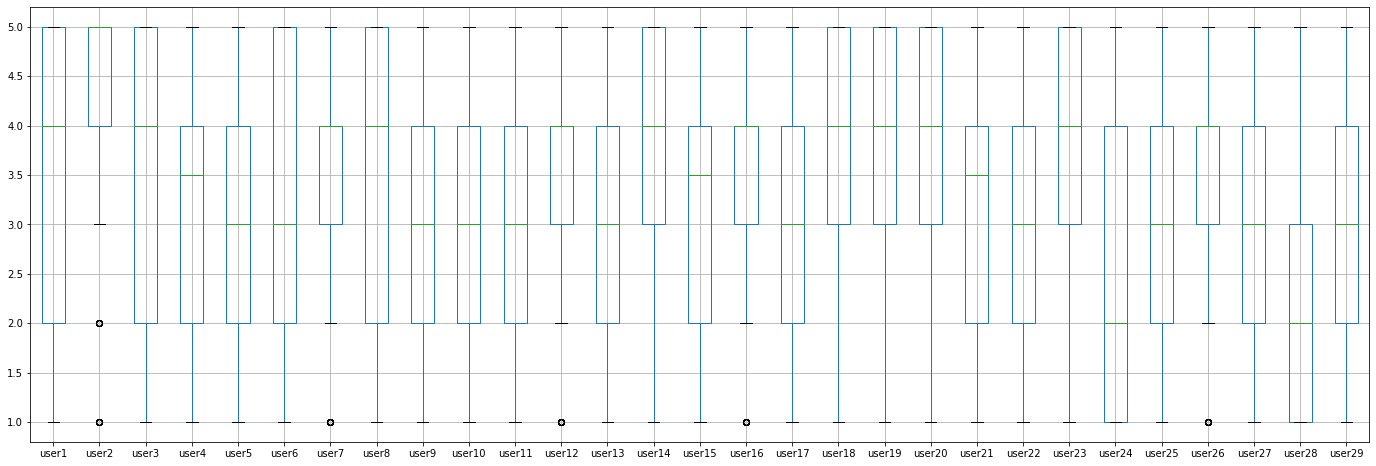

In [5]:
# adjust the figure size of matplotlib
matplotlib.rc('figure', figsize=(24, 8))

# use `plt.boxplot` to create boxplots based on the dataframe `raw_ratings`, here `user_cols` can be used as labels
#plt.boxplot(...)  # TBD

boxplot = raw_ratings.boxplot()
boxplot.plot()

# save figure
savefig("bb_user.pdf")

# checkout the plot and print at least two "not so trust-able" users
print("user:7 and user:16 are not so trustable")  # TBD

Using `raw_ratings` we can simply checkout pairwise correlations between user ratings,
here the pandas method [corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) 
should be used, the default correlation measure is the pearson correlation coefficient.

,user1,user2,user3,user4,user5,user6,user7,user8,user9,user10,...,user20,user21,user22,user23,user24,user25,user26,user27,user28,user29
user1,1.000000,0.835385,0.858281,0.835197,0.777055,0.865779,0.664843,0.842064,0.749014,0.837410,...,0.770085,0.831371,0.828158,0.841501,0.817526,0.854463,0.785486,0.847328,0.817050,0.826770
user2,0.835385,1.000000,0.845162,0.779037,0.777936,0.798677,0.737338,0.821037,0.643633,0.798561,...,0.830955,0.826960,0.807445,0.866796,0.702138,0.802336,0.802035,0.808235,0.706145,0.821424
user3,0.858281,0.845162,1.000000,0.857651,0.795284,0.860588,0.706449,0.882326,0.677261,0.830062,...,0.808445,0.842873,0.837869,0.839140,0.752348,0.844506,0.789218,0.880788,0.793968,0.833749
user4,0.835197,0.779037,0.857651,1.000000,0.818480,0.851705,0.659126,0.828459,0.704996,0.790059,...,0.759849,0.839102,0.809265,0.829851,0.808316,0.823736,0.790866,0.864194,0.826444,0.833129
user5,0.777055,0.777936,0.795284,0.818480,1.000000,0.782784,0.609236,0.775792,0.619146,0.733501,...,0.726865,0.748735,0.741272,0.791722,0.710877,0.756331,0.699997,0.800932,0.738045,0.765405


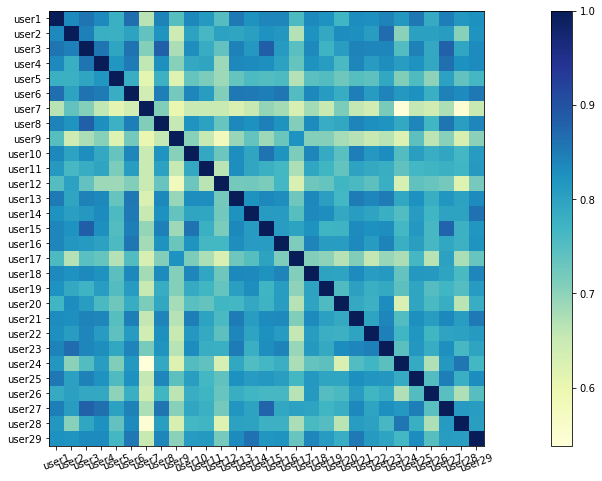

In [6]:
# display a table with all pairwise correlations of all users
correlations = raw_ratings.corr()   # TBD

d(correlations.head())  

# a heat map can be used for further investigation
heat_map(correlations)

,USER,CORR
6,user7,0.666171
8,user9,0.693694


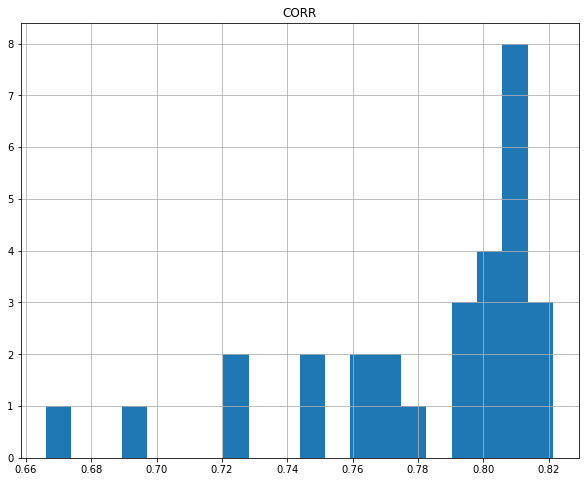

In [7]:
# aggregate the estimated correlations: so for each user a mean correlation value is stored
mean_values = correlations.mean()   # TBD
mean_values = mean_values.to_frame().reset_index()  # TBD rename columns
mean_values.rename(columns={'index': 'USER', 0: 'CORR'},inplace=True)
# the result should be a dataframe <USER> <CORR>

# sort dataframe by correlation value
mean_values = mean_values.sort_values(by=['CORR'])   # TBD sort values by correlation

# show the two worst correlating users
d(mean_values.head(2))  

# adjust the figure size of matplotlib
matplotlib.rc('figure', figsize=(10, 8))

# plot a histogram of these mean correlations, with 20 bins
  # TBD
mean_values.hist(bins=20)
savefig("hist_user_pair_corr.pdf")

,video_name,var
177,water_netflix_7500kbps_2160p_59.94fps_vp9.mkv,1.044335
104,surfing_sony_8bit_2000kbps_1080p_59.94fps_hevc...,0.995074
117,surfing_sony_8bit_7500kbps_2160p_59.94fps_vp9.mkv,0.980296
158,water_netflix_15000kbps_2160p_59.94fps_h264.mp4,0.933498
105,surfing_sony_8bit_7500kbps_1080p_59.94fps_hevc...,0.923645
84,cutting_orange_tuil_2000kbps_1080p_59.94fps_vp...,0.886700
120,vegetables_tuil_200kbps_360p_59.94fps_h264.mp4,0.881773
64,cutting_orange_tuil_2000kbps_1080p_59.94fps_h2...,0.864532
146,vegetables_tuil_15000kbps_1080p_59.94fps_vp9.mkv,0.820197
74,cutting_orange_tuil_2000kbps_1080p_59.94fps_he...,0.812808


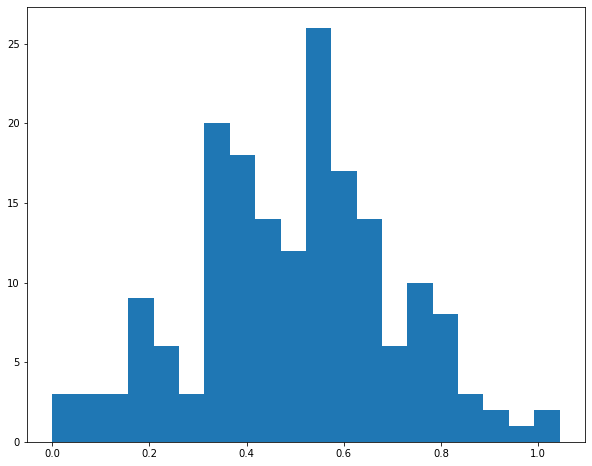

In [8]:
# check "hard to rate videos"
# in the following a "hard-to-rate" video is a video with a high variance of ratings per user
# the rationale behind this analysis, is that there are videos that are easy to rate, 
#   thus a low variance in ratings can be estimated, and a video is hard-to-rate if this variance is high
var_list=[]
for x in range(numer_of_stimuli):
    var_list.append(raw_ratings.iloc[x,1:].var())
    
raw_ratings["var"] = var_list # TBD calculate variance
raw_ratings = raw_ratings.sort_values(by=['var'], ascending=[False])   # TBD sort by variance
d(raw_ratings[["video_name", "var"]].head(10))  # show 10 hard-to-rate videos


# adjust the figure size of matplotlib
matplotlib.rc('figure', figsize=(10, 8))

  # TBD plot a histogram with 20 bins for the `var` column
plt.hist(raw_ratings['var'], bins = 20)
savefig("hist_var_stimuli.pdf")

### Subtask 1.2: A simple outlier detector
In the previous analysis, we figured out that there are some users who do not rate as the majority of participants, moreover we further found sequences that are hard-to-rate.
As next, we will implement the following simple outlier-detection algorithm, based on the method used in ITU-T P.1203 and P.1204 and originates from [ITU-T Rec. P.913 (Annex A)](https://www.itu.int/rec/T-REC-P.913-202106-I/en).

* calculate mean opinion scores of all participants for each stimulus, this is assumed to be the ground_truth_mos
* for each user calculate pearson correlation (PCC) of all ratings to the estimated ground_truth_mos
    * if PCC < 0.75
        * the user is supposed to be an outlier
    * else: everything is fine

* users that are classified as outliers are excluded from the ratings

In [9]:
# calculate ground_truth_mos, please use dataframe.apply as aggregation method, 
#    see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
#    hint: as mentioned in the python_science_stack_intro the axis parameter of apply is important

raw_ratings["mos"] = raw_ratings.loc[:,'user1': 'user29'].apply(np.mean, axis=1)  # TBD

d(raw_ratings[["video_name", "mos"]])


outliers = []  # collect usernames that are as outlier classified here
# TBD start
# iterate over all users, and calculate PCC, and perform outlier check
for x in user_cols:
    # PCC of all ratings
    PCC = raw_ratings[x].corr(raw_ratings['mos'])
    if PCC < 0.75:
        outliers.append(x)
    else:
        pass
# TBD end

print(f"the method detected {len(outliers)} outliers: {outliers}")

,video_name,mos
177,water_netflix_7500kbps_2160p_59.94fps_vp9.mkv,3.482759
104,surfing_sony_8bit_2000kbps_1080p_59.94fps_hevc...,2.931034
117,surfing_sony_8bit_7500kbps_2160p_59.94fps_vp9.mkv,4.137931
158,water_netflix_15000kbps_2160p_59.94fps_h264.mp4,2.827586
105,surfing_sony_8bit_7500kbps_1080p_59.94fps_hevc...,4.068966
...,...,...
110,surfing_sony_8bit_200kbps_360p_59.94fps_vp9.mkv,1.103448
10,american_football_harmonic_200kbps_360p_59.94f...,1.068966
162,water_netflix_750kbps_720p_59.94fps_hevc.mp4,1.034483
160,water_netflix_200kbps_360p_59.94fps_hevc.mp4,1.000000


the method detected 1 outliers: ['user7']


### Subtask 1.3: MOS calculation and CI + SOS
As next, we will calculate the final mean opinion scores and further calculate confidence intervals.
Moreover, as a method to check the reliability of a conducted test, the SOS plot can help, (cf. [Hoßfeld 2011- SOS: The MOS is not enough!](https://www.researchgate.net/publication/220773357_SOS_The_MOS_is_not_enough)).

The 95%-CI values are estimated as follows,:

$$[low,high] = \overline{x} \pm ci_{95\%} $$

$low$ and $high$ would be the intervals for plots.
The $ci_{95\%} = 1.96 \cdot \frac{\sigma}{\sqrt{n}}$.

It should be noted that the recommended ways to estimate $ci_{95\%}$ is different, see [ITU-T Recommendation P.1401 (Appendix III)](https://www.itu.int/rec/T-REC-P.1401-202001-I/en), here it is recommended to use [student's-t value](https://en.wikipedia.org/wiki/Student%27s_t-distribution), and not $1.96$ as factor.
We use $1.96$ here, it is based on the standard normal distribution, because the number of participants $n>=24$ is large enough.
Even if the student's-t value would be used, the introduced error is negligible.

In [10]:
# remove the outliers from columns, so we create a copy of a cleaned dataframe, 
#   that does not include outlier columns
raw_ratings_wo_outliers = raw_ratings.drop(outliers, axis=1)    # TBD

# update user_cols (remove as outlier classified users)
user_cols_wo_outliers = (raw_ratings_wo_outliers.columns).drop(['video_name','mos','var'])  # TBD

# recalculate MOS

raw_ratings_wo_outliers["mos"] = raw_ratings_wo_outliers[user_cols_wo_outliers].apply(np.mean, axis=1)  # TBD

d(raw_ratings_wo_outliers.head())

,video_name,user1,user2,user3,user4,user5,user6,user8,user9,user10,...,user22,user23,user24,user25,user26,user27,user28,user29,var,mos
177,water_netflix_7500kbps_2160p_59.94fps_vp9.mkv,4,5,2,2,3,3,3,5,4,...,3,4,2,4,5,2,2,4,1.044335,3.500000
104,surfing_sony_8bit_2000kbps_1080p_59.94fps_hevc...,3,5,4,1,2,3,3,3,4,...,2,3,1,4,4,2,1,3,0.995074,2.892857
117,surfing_sony_8bit_7500kbps_2160p_59.94fps_vp9.mkv,3,5,5,3,3,5,5,4,4,...,3,4,1,3,5,4,3,4,0.980296,4.107143
158,water_netflix_15000kbps_2160p_59.94fps_h264.mp4,3,4,2,3,4,2,3,2,2,...,3,4,1,3,3,2,3,3,0.933498,2.821429
105,surfing_sony_8bit_7500kbps_1080p_59.94fps_hevc...,5,5,5,4,4,5,3,5,4,...,4,5,2,3,5,4,2,4,0.923645,4.071429


In [11]:
# calculate ci_95%, and std

def ci_value(x):
    deviation = x['std']
    y = len(raw_ratings_wo_outliers.loc[:,'user1': 'user29'].head(0).columns)
    ci = 1.96*(deviation/(np.sqrt(y)))
    return ci  # TBD


#raw_ratings_wo_outliers["ci"] = ci_value(raw_ratings_wo_outliers)   # TBD

# we further calculate standard deviation
#raw_ratings_wo_outliers["std"] = raw_ratings_wo_outliers['var'].apply(np.sqrt)  #TBD
raw_ratings_wo_outliers["std"] = raw_ratings_wo_outliers['var'].apply(np.sqrt)  #TBD
raw_ratings_wo_outliers["ci"] =  ci_value(raw_ratings_wo_outliers) # TBD 

# show results
d(raw_ratings_wo_outliers[["mos", "ci", "std"]].head())

# save the cleaned ratings
raw_ratings_wo_outliers.to_csv("mos.csv", index=False)

,mos,ci,std
177,3.500000,0.378527,1.021927
104,2.892857,0.369492,0.997534
117,4.107143,0.366738,0.990099
158,2.821429,0.357877,0.966177
105,4.071429,0.355983,0.961065


Text(0.5, 1.0, 'estimated a: 0.241')

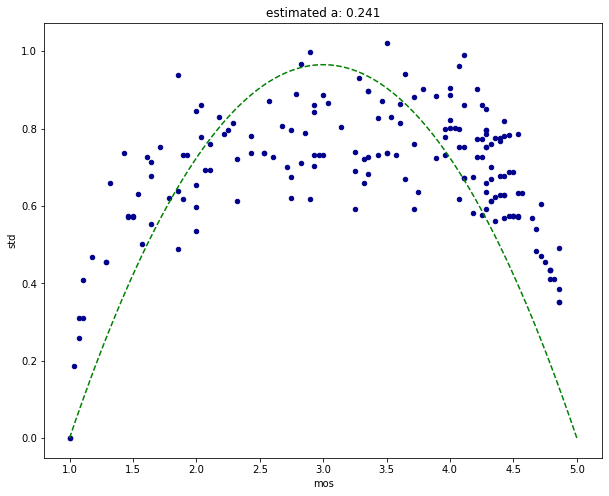

In [12]:
# SOS plot.

# the general idea of an SOS plot is that the x-axis corresponds to MOS per stilumi,
#    and the y-axis corresponds to the std value of the ratings, usually a scatterplot is used

# plot the SOS plot using pandas and raw_ratings_wo_outliers
ax = raw_ratings_wo_outliers.plot.scatter(x = 'mos', y = 'std', c = 'Darkblue');   # TBD

# as next, we will fit the quadratic function f(x) = -a(x-5)*(x-1) = -ax^2+ 6ax -5a , referred as SOS-Hypothesis

x_data = raw_ratings_wo_outliers['mos']   # TBD get all MOS values
y_data = raw_ratings_wo_outliers['std']  # TBD get all std values


# for curve fitting we will use scipy.optimize.curve_fit  (already imported as curve_fit)
#   checkout https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

# define the fitting function
def fitting_function(x, a):
    return  -a*(x**2)+ (6*a*x) -(5*a)   # TBD

# perform the curve fit
popt, pcov = curve_fit(fitting_function, x_data, y_data)   # TBD

# add fitted curve to plot
x = np.linspace(1, 5, 100)
ax.plot(x, fitting_function(x, *popt), 'g--')
ax.set_title(f"estimated a: {popt[0].round(3)}")

# `a` is now an indicator for your test reliability, a value around 0.2 is ok for video quality test

## Subtask 2: FFprobe meta data
As next, we will use ffprobe to extract meta-data of videos segments, we have encoded such segments in the last task sheet, here it is important that each "segment" is playable, thus the video-header + video-data needs to be one file. We investigated in ts03, how this can be done.

Our extracted features form the basis for our later developed no-reference bitstream-data based video quality prediction model.
According to ITU-T's P.1204/P.1203 family of bitstream based models our developed model falls into the category "mode0" (with some extensions), thus it has access to:

* video_framerate
* video_bits_per_pixel
* video_pixel_format
* video_codec
* video_bitrate (average over the segment)
* video_height
* video_width
* video_codec_profile

All the mentioned parameters can be extracted using [ffprobe](https://ffmpeg.org/ffprobe.html), a tool that is part of the ffmpeg-tool chain.

In [13]:
# lets first check if ffprobe runs and is correctly downloaded, 
#   the download should have been performed in the first code cell

print(f"{ffprobe}")  # should point to the correct local installed ffprobe path, 
#  so depending on your system tools/ffmpeg*

# because ffprobe is a command line tool, and usually writes all extracted data to stdout on the console, 
#   we need to have a helper method that stores such output, such a method is provided as `shell_call`

ffprobe_version = shell_call(f"{ffprobe} -version")

print(ffprobe_version)
print()

# run ffprobe for the following video file, to extract the duration [s] of the video,
# use as output format json (shell_call will just return the formatted json string)
video_file = os.path.join(
    "videos",
    "bigbuck_bunny_8bit_200kbps_360p_60.0fps_h264.mp4"
)

# please use pythons formatting string syntax
# for example checkout https://realpython.com/python-f-strings/

print(shell_call(f"{ffprobe} -v error -show_entries format=duration -of default=noprint_wrappers=1:nokey=1 {video_file}"))  # TBD

tools\ffprobe.exe
ffprobe version 4.2.2 Copyright (c) 2007-2019 the FFmpeg developers
built with gcc 9.2.1 (GCC) 20200122
configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt
libavutil      56. 31.100 / 56

### Subtask 2.1: FFprobe feature extraction mode0
In the following, we use ffprobe to extract the required features for a mode 0 style model.

In [14]:
# build ffprobe command to extract meta-data of the video stream
# use pythons formatting syntax to automatically add the video_file used in the previous cell


cmd = f"{ffprobe} -show_format -show_streams -print_format json -loglevel quiet {video_file}"  # TBD

raw_result = shell_call(cmd)
print(raw_result)  

# use python's json lib to transfer the string to a json object (see [json](https://docs.python.org/3/library/json.html)),
result = json.loads(raw_result)  # TBD

# print some important parts of this result, 
# important is that you use the json object to access such fields, here you can assume the following
#    the media file under probe has always exactly one video stream

# required data to be extracted:
# width
# height
# codec_name
# pix_fmt
# bits_per_raw_sample
# avg_frame_rate
# bit_rate
# profile
# pix_fmt


video_width = result['streams'][0]['width'] # TBD
video_height = result['streams'][0]['height']  # TBD
video_codec = result['streams'][0]['codec_name'] # TBD
video_pixel_format = result['streams'][0]['pix_fmt']  # TBD
video_bpp = result['streams'][0]['bits_per_raw_sample']  # TBD
video_fps = result['streams'][0]['avg_frame_rate'] # TBD
video_bitrate = result['streams'][0]['bit_rate'] # TBD
video_codec_profile = result['streams'][0]['profile']  # TBD

print(
    video_width,
    video_height,
    video_codec,
    video_pixel_format,
    video_bpp,
    video_fps,
    video_bitrate,
    video_codec_profile,
    video_pixel_format
)

  
assert(video_width == 640)
assert(video_height == 360)
assert(video_codec == "h264")
assert(video_pixel_format == "yuv422p")
assert(video_bpp == "8")
assert(video_fps == "60/1")
assert(video_bitrate == "210039")
assert(video_codec_profile == "High 4:2:2")

{
    "streams": [
        {
            "index": 0,
            "codec_name": "h264",
            "codec_long_name": "H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10",
            "profile": "High 4:2:2",
            "codec_type": "video",
            "codec_time_base": "1/120",
            "codec_tag_string": "avc1",
            "codec_tag": "0x31637661",
            "width": 640,
            "height": 360,
            "coded_width": 640,
            "coded_height": 368,
            "has_b_frames": 2,
            "sample_aspect_ratio": "1:1",
            "display_aspect_ratio": "16:9",
            "pix_fmt": "yuv422p",
            "level": 31,
            "chroma_location": "left",
            "refs": 1,
            "is_avc": "true",
            "nal_length_size": "4",
            "r_frame_rate": "60/1",
            "avg_frame_rate": "60/1",
            "time_base": "1/15360",
            "start_pts": 507,
            "start_time": "0.033008",
            "duration_ts": 153600,
           

In [15]:
def parse_fps(fps_str):
    """helper method to convert a fps string to a number
        possible fps_str could be "A/B" or "A"
    """
    # TBD start
    if fps_str.find('/')>1:
        x = fps_str.find('/')
        fps_str1=fps_str[:x]
        fps_str2=fps_str[x+1:]
 
        fps_str1 = float(fps_str1)
        fps_str2 = float(fps_str2)
 
        fps_final = fps_str1/fps_str2
        return fps_final
 
    elif fps_str.find('/')<1:
        fps_str = float(fps_str)
        return fps_str

    # TBD end

print(parse_fps("60/1"))
print(parse_fps("60"))

assert(parse_fps("60/1") == 60.0)
assert(parse_fps("60") == 60.0)

60.0
60.0


In [16]:
# put everything inside a method, so that we can use this later
def extract_mode0_features(video_file):
    """extracts video features: 
            width, height, codec_name, pix_fmt, bits_per_raw_sample, avg_frame_rate, bit_rate, profile, pix_fmt
       important here, some features, e.g. avg_frame_rate are encoded as string inside the json report, 
       for such features it is required to transform them to suitable numeric formats, e.g. use parse_fps
       
       returns a dictionary of the feature values, e.g.
       {
       'video_width': 640, 
       'video_height': 360, 
       'video_codec': 'h264', 
       'video_pixel_format': 'yuv422p', 
       'video_bpp': 8, 
       'video_fps': 60.0, 
       'video_bitrate': 210039, 
       'video_codec_profile': 'High 4:2:2'
       }
       
       return {} in case of an error, and print out on stdout what kind of error happened, 
           e.g. the video file does not exist
           
        **important**
        for some videos the meta data does not include all information, e.g.
            bits_per_raw_sample --> here assume 8 in case the data field is not accessible
            bit_rate not in stream part of ffprobe (e.g. in case of vp9), here you can use
                ffprobe_result["format"]["bit_rate"] as bitrate
    """
    
    if not os.path.isfile(video_file):
        print(f"{video_file} does not exist")
        return {}
    result = {}
    # TBD start
    cmd = f"{ffprobe} -show_format -show_streams -print_format json -loglevel quiet {video_file}"
   
    raw_result = shell_call(cmd)
   
    result = json.loads(raw_result)
 
    streamtemp = 'bits_per_raw_sample' in result['streams'][0]
 
    bitRatetemp = 'bit_rate' in result['streams'][0]
 
    if streamtemp:
        video_bpp =  result['streams'][0]['bits_per_raw_sample']# TBD
    else:
        video_bpp = int(8)
   
    if bitRatetemp:
        video_bitrate = result['streams'][0]['bit_rate']
    else:
        video_bitrate = result["format"]["bit_rate"]
   
    video_width = result['streams'][0]['width']# TBD
    video_height = result['streams'][0]['height'] # TBD
    video_codec = result['streams'][0]['codec_name'] # TBD
    video_pixel_format = result['streams'][0]['pix_fmt'] # TBD
    video_fps = result['streams'][0]['avg_frame_rate'] # TBD
    video_codec_profile = result['streams'][0]['profile'] # TBD
   
   
    result = {'video_width': video_width,
              'video_height': video_height,
              'video_codec': video_codec,
              'video_pixel_format': video_pixel_format,
              'video_bpp': int(video_bpp),
              'video_fps': parse_fps(video_fps),
              'video_bitrate': int(video_bitrate),
              'video_codec_profile': video_codec_profile
              }
    
    
    # TBD end
    return result


d(extract_mode0_features(video_file))


assert(extract_mode0_features(video_file) == {
    'video_width': 640, 
    'video_height': 360, 
    'video_codec': 'h264', 
    'video_pixel_format': 'yuv422p', 
    'video_bpp': 8, 
    'video_fps': 60.0, 
    'video_bitrate': 210039, 
    'video_codec_profile': 'High 4:2:2'
    }
)

test_video_file = os.path.join(
    "videos",
    "cutting_orange_tuil_200kbps_360p_59.94fps_hevc.mp4"
)

assert(extract_mode0_features(test_video_file) == {
    'video_width': 640,
    'video_height': 360,
    'video_codec': 'hevc',
    'video_pixel_format': 'yuv422p',
    'video_bpp': 8,
    'video_fps': 59.94006309148265,
    'video_bitrate': 117453, 
    'video_codec_profile': 'Rext'
    }
)

{'video_width': 640,
 'video_height': 360,
 'video_codec': 'h264',
 'video_pixel_format': 'yuv422p',
 'video_bpp': 8,
 'video_fps': 60.0,
 'video_bitrate': 210039,
 'video_codec_profile': 'High 4:2:2'}

### Subtask 2.2: Feature extraction for several videos
So far we developed a method to extract features for a single video file, whereas usually, a subjective dataset consists of several videos. 
In the following, we will use the previously developed method to extract features of several files, and moreover, we will store all results in a pandas dataframe.

In [17]:
# extract the ffprobe features for all videos stored in videos/
# use glob.glob(...) (part of python3's glob lib) to get all the video files inside the folder,
#    checkout [glob](https://docs.python.org/3/library/glob.html)

all_features = [] # here all features are stored
for video_filename in glob.glob('videos/*'): # TBD
    # TBD start
    all_features.append(extract_mode0_features(video_filename))
    # TBD end

In [18]:
# create a pandas dataframe based for the collected all_features list

dextracted_features = pd.DataFrame(all_features)   # TBD

d(dextracted_features.head())

d(f"processed videos: {len(dextracted_features)}")
# save the extracted features as csv file `features.csv`, ignore the index
dextracted_features.to_csv('features.csv', index=False)  # TBD

,video_width,video_height,video_codec,video_pixel_format,video_bpp,video_fps,video_bitrate,video_codec_profile
0,1920,1080,h264,yuv422p,8,60.0,2051540,High 4:2:2
1,640,360,h264,yuv422p,8,60.0,210039,High 4:2:2
2,640,360,hevc,yuv422p,8,60.0,199745,Rext
3,640,360,vp9,yuv422p,8,60.0,202503,Profile 1
4,640,360,h264,yuv422p,8,60.0,772037,High 4:2:2


'processed videos: 39'

## Subtask 3:  A meta-data based model
In the next cells, we will develop a meta-data based video quality model, for this reason, we use features that are extracted with the methods of the previous tasks, here all features are stored already in the file `test_1_features.csv`.

Moreover, the quality ratings are given in the file `test_1_mos.csv`, it was similarly created as we did it in Subtask 1.

Building a model consists of several steps:
* investigation of features that correspond to the prediction target (here quality rating aka 'mos')
* pre-process features, e.g. convert some features to log(feature)
* define a training and validation dataset, e.g. 50%-50% split without common source videos
* define possible fitting function candidates and train them with a curve fitting method
* evaluate using several state-of-the-art performance metrics, e.g. pearson correlation, root-mean-square-error

We will go through all these steps in the following code cells.

In [19]:
# lets read both csv files with pandas and check the content

dmeta = pd.read_csv("test_1_features.csv")  # TBD
d(dmeta.head())
dmos = pd.read_csv("test_1_mos.csv") # TBD

d(dmos.head())

# combine both dataframes using pandas.merge function, see [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)
#    merge keys are on both sides "video_name", this is similar to a "join on" in the database sql world

dfeatures = dmeta.merge(dmos)  # TBD
d(dfeatures.head())

assert(len(dfeatures) == len(dmos) == len(dmeta))
assert(len(dfeatures.columns) == 11)

,video_width,video_height,video_codec,video_pixel_format,video_bpp,video_fps,video_bitrate,video_codec_profile,video_name
0,1920,1080,hevc,yuv422p,8,59.940063,13849676,Rext,american_football_harmonic_15000kbps_1080p_59....
1,1920,1080,vp9,yuv422p,8,59.940063,14910968,Profile 1,american_football_harmonic_15000kbps_1080p_59....
2,1920,1080,h264,yuv422p,8,59.940063,15706046,High 4:2:2,water_netflix_15000kbps_1080p_59.94fps_h264.mp4
3,1920,1080,hevc,yuv422p,8,59.940063,7417814,Rext,cutting_orange_tuil_7500kbps_1080p_59.94fps_he...
4,3840,2160,h264,yuv422p,8,59.940063,7930027,High 4:2:2,cutting_orange_tuil_7500kbps_2160p_59.94fps_h2...


,video_name,mos,ci
0,american_football_harmonic_200kbps_360p_59.94f...,1.000000,0.000000
1,american_football_harmonic_750kbps_360p_59.94f...,2.137931,0.252234
2,american_football_harmonic_750kbps_720p_59.94f...,1.655172,0.201139
3,american_football_harmonic_2000kbps_720p_59.94...,3.034483,0.266082
4,american_football_harmonic_2000kbps_1080p_59.9...,2.344828,0.262378


,video_width,video_height,video_codec,video_pixel_format,video_bpp,video_fps,video_bitrate,video_codec_profile,video_name,mos,ci
0,1920,1080,hevc,yuv422p,8,59.940063,13849676,Rext,american_football_harmonic_15000kbps_1080p_59....,4.413793,0.228479
1,1920,1080,vp9,yuv422p,8,59.940063,14910968,Profile 1,american_football_harmonic_15000kbps_1080p_59....,4.379310,0.246344
2,1920,1080,h264,yuv422p,8,59.940063,15706046,High 4:2:2,water_netflix_15000kbps_1080p_59.94fps_h264.mp4,3.620690,0.313899
3,1920,1080,hevc,yuv422p,8,59.940063,7417814,Rext,cutting_orange_tuil_7500kbps_1080p_59.94fps_he...,4.103448,0.245016
4,3840,2160,h264,yuv422p,8,59.940063,7930027,High 4:2:2,cutting_orange_tuil_7500kbps_2160p_59.94fps_h2...,4.206897,0.313379


### Subtask 3.1: Identification of functional dependencies
After we read the features and joined the quality ratings to the corresponding video files, we can now have a deeper look into the connection between the features.

Assuming you have a small number of features, e.g. pandas [scatter_matrix](https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html), (hint: there is no guide on how to handle such analysis, usually during model development you would use several possible approaches to visualize and measure)

In [20]:
# non-numerical features are excluded from the scatter matrix plot, however we have some features of this type

# lets have a look on them
print(set(dfeatures["video_pixel_format"].values))  # there is always one value used, 
# so there is no information that we can get out of this feature

print(set(dfeatures["video_codec"].values)) # so here some more values are stored inside the data
# for this reason we will create a new column, that is a numerical representation of the video codec
# for simplicity, we use a simple mapping

codec_mapping = {
    'h264': 0, 
    'hevc': 1, 
    'vp9': 2
}

# apply the codec mapping
dfeatures["video_codec_num"] =  [codec_mapping[item] for item in dfeatures.video_codec] # TBD

print(set(dfeatures["video_codec_profile"].values))
# video_codec_profile also seems to be feasible, so we encoded it also with a simple mapping

profile_mapping = {
    'Profile 1': 0, 
    'Rext': 1, 
    'High 4:2:2': 2
}
# apply the video codec profile mapping
dfeatures["video_codec_profile_num"] = [profile_mapping[item] for item in dfeatures.video_codec_profile]   # TBD

{'yuv422p'}
{'h264', 'vp9', 'hevc'}
{'Profile 1', 'Rext', 'High 4:2:2'}


You may be a bit concerned about this simple way of categorical feature mapping because usually such string features would be encoded with [one-hot-encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).
However our integer mapping semantically for `video_codec` and `video_codec_profile` does not follow such an ordinal relationship, but it further depends on what kind of model we develop in the end (cf. [one-hot-encoding-tree-models](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769)).

[]

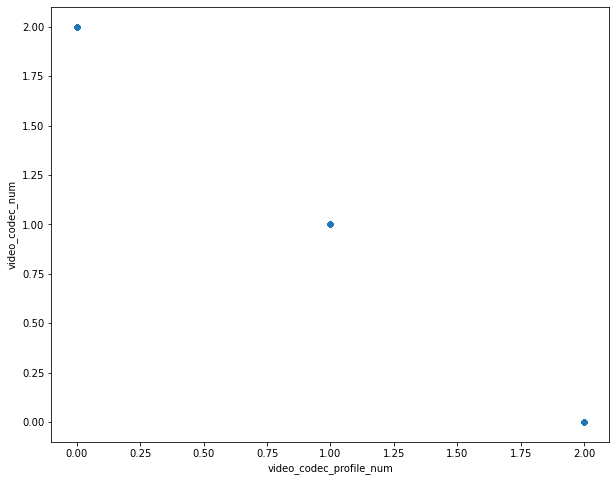

In [21]:
# lets first check how video_codec_num and video_codec_profile_num behave.

# plot video_codec_num and video_codec_profile_num using a scatter plot
ax =  dfeatures.plot.scatter(x='video_codec_profile_num', y='video_codec_num')# TBD
ax.plot()
# you can hopefully can see that these feature values match perfectly, so we don't need one of them

C:\Users\Qasim Ali\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:89: UserWarning: Attempting to set identical left == right == 8.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\Qasim Ali\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:90: UserWarning: Attempting to set identical bottom == top == 8.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\Users\Qasim Ali\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 8.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


array([[<AxesSubplot:xlabel='video_width', ylabel='video_width'>,
        <AxesSubplot:xlabel='video_height', ylabel='video_width'>,
        <AxesSubplot:xlabel='video_bpp', ylabel='video_width'>,
        <AxesSubplot:xlabel='video_fps', ylabel='video_width'>,
        <AxesSubplot:xlabel='video_bitrate', ylabel='video_width'>,
        <AxesSubplot:xlabel='mos', ylabel='video_width'>,
        <AxesSubplot:xlabel='video_codec_num', ylabel='video_width'>,
        <AxesSubplot:xlabel='video_codec_profile_num', ylabel='video_width'>],
       [<AxesSubplot:xlabel='video_width', ylabel='video_height'>,
        <AxesSubplot:xlabel='video_height', ylabel='video_height'>,
        <AxesSubplot:xlabel='video_bpp', ylabel='video_height'>,
        <AxesSubplot:xlabel='video_fps', ylabel='video_height'>,
        <AxesSubplot:xlabel='video_bitrate', ylabel='video_height'>,
        <AxesSubplot:xlabel='mos', ylabel='video_height'>,
        <AxesSubplot:xlabel='video_codec_num', ylabel='video_height'>,


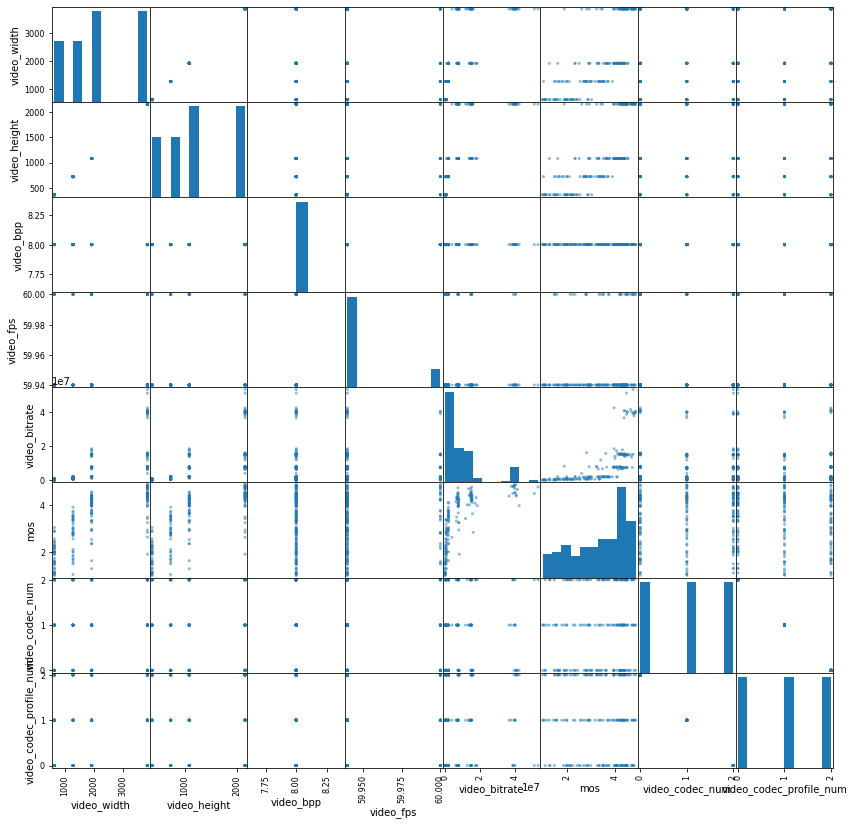

In [22]:
# lets plot an overview of all numeric features
# important, exclude the video_name and ci column from the scatter matrix plot

# adjust the figure size of matplotlib, square size, so that the scatter matrix plot looks proper
matplotlib.rc('figure', figsize=(14, 14))
df_new = dfeatures.copy()
df_new.drop(['video_name','ci'], axis=1,inplace=True)
pd.plotting.scatter_matrix(df_new)
 # TBD

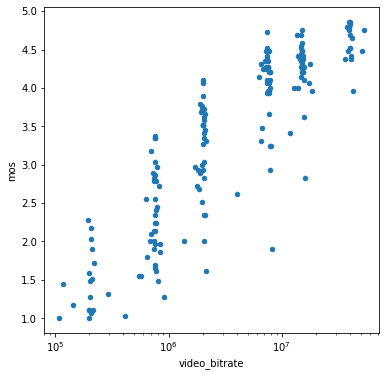

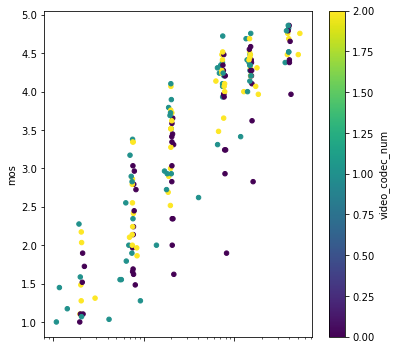

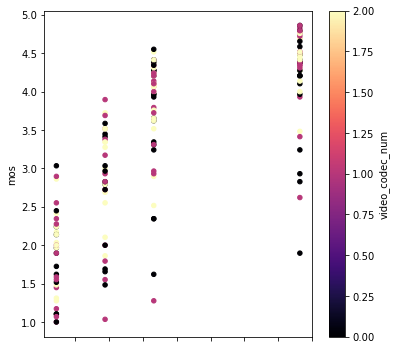

In [23]:
# mos~video_bitrate seems to be promising, so lets have a deeper look into this feature

# re-adjust figure size, can also be done inside the plot call with  figsize=(6,6)
matplotlib.rc('figure', figsize=(6, 6))

# using a scatter plot (y axis = mos, x = video_bitrate)
ax = dfeatures.plot.scatter(x = 'video_bitrate', y = 'mos')

# use log scaling for x axis
ax.set_xscale('log')
# there seems to be a connection, now make a break and watch a [video](https://www.youtube.com/watch?v=I3sKIV6KugA) ;) 

# lets color the last plot by video codec (pass colormap='viridis' as additional parameter to the plot)
ax = dfeatures.plot.scatter(x = 'video_bitrate', y ='mos',c = 'video_codec_num',colormap='viridis');  # TBD
ax.set_xscale('log')

# so there seems to be a shift by the h264 bitrates compared to vp9 and hevc, we will handle this later

# also the video height/width seems to have an influence (according to the scatter matrix plot)
# lets check video height as color for the plot (use colormap='magma')

ax = dfeatures.plot.scatter(x = 'video_height', y = 'mos',c = 'video_codec_num',colormap='magma');
# it can be seen larger height value leads to higher quality

h264
hevc
vp9


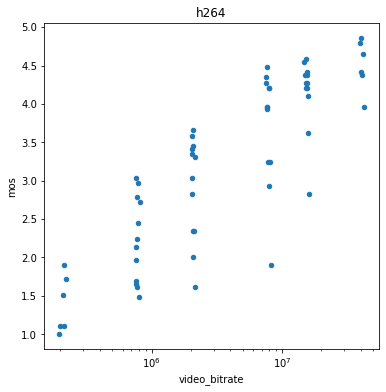

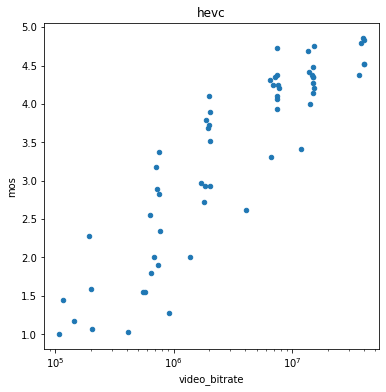

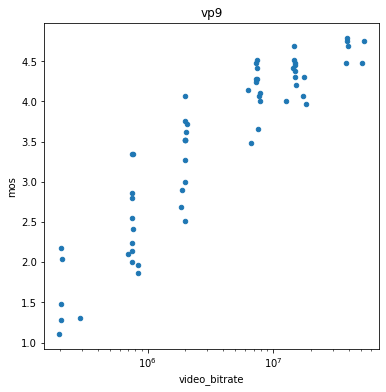

In [24]:
# lets checkout the video_bitrate~mos, per video codec

# so we group our features by video_codec and create separate scatter plots (we again use logx scaling), 
# as title for each plot we use the corresponding video_codec 

for i, grp in dfeatures.groupby(by="video_codec"):
    print(i)
    ax =  grp.plot.scatter(x='video_bitrate', y='mos');
    ax.set_xscale('log')
    ax.set_title(i)
    # TBD

### Subtask 3.2: Preprocess features
We hopefully observed the following connections in the last cells:

* log(video_bitrate) is somehow linearly connected to quality (depending on the video codec)
* there are features that have 0 impact, e.g. video profile, or video_fps (according to the given data; be sure about that some conclusions are just based on the given data)
* the resolution (video_height/width) has an influence on the quality

In the next cells, we will check out how to measure such influences, and will create some compound features.


In [25]:
# as indicator if a feature is good or not we use correlation measures for simplicity, 
# here also other methods can be used (e.g. checkout https://machinelearningmastery.com/calculate-feature-importance-with-python)

# lets start with video_bitrate and mos

# display pearson correlation table using pandas
d(dfeatures['video_bitrate'].corr(dfeatures['mos'], method = 'pearson'))   # TBD

# display kendall correlation table using pandas
d(dfeatures['video_bitrate'].corr(dfeatures['mos'], method='kendall')) # TBD

# display spearman correlation table using pandas
d(dfeatures['video_bitrate'].corr(dfeatures['mos'], method = 'spearman')) # TBD

0.6431950406241695

0.6653041087350712

0.8558574776063163

In [26]:
# put everything in a method, to returns such correlations in one go

def feature_corr(dataframe, column_a, column_b):
    """calculates several correlation values for column_a vs column_b 

    returns a dictionary, e.g. 
    {
        'check': 'mos~video_bitrate',
        'pearson': 0.6431950406241694,
        'kendall': 0.6653041087350712,
        'spearman': 0.8558574776063163
    }
    """
    result = {
        "check": f"{column_a}~{column_b}"
    }
    # TBD start
    pearson_val = dataframe[column_a].corr(dataframe[column_b], method = 'pearson')
    kendall_val = dataframe[column_a].corr(dataframe[column_b], method='kendall')
    spearman_val = dataframe[column_a].corr(dataframe[column_b], method='spearman')
    
    result['pearson'] = pearson_val
    result['kendall'] = kendall_val
    result['spearman'] = spearman_val

    # TBD end
    return result

print(feature_corr(dfeatures, "mos", "video_bitrate"))
assert(feature_corr(dfeatures, "mos", "video_bitrate") == {
    'check': 'mos~video_bitrate', 
    'pearson': 0.6431950406241694, 
    'kendall': 0.6653041087350712, 
    'spearman': 0.8558574776063163
    }
)

{'check': 'mos~video_bitrate', 'pearson': 0.6431950406241695, 'kendall': 0.6653041087350712, 'spearman': 0.8558574776063163}


AssertionError: 

In [27]:
# so now we can use the previous method to calculate a bunch of correlations to mos
print(dfeatures.columns)

corr_values = []  # collect all correlation values
for col in ["video_width", "video_height", "video_codec_num", "video_bitrate"]:
    corr_values.append(feature_corr(dfeatures, "mos", col)) # TBD
    
    # TBD

# show the results as table, sort by pearson
d(pd.DataFrame(corr_values).sort_values(by="pearson"))

# so we can see, height and width have same pearson correlation 
#   (this is due to the fixed aspect ratio inside our data, it's always good to have some explanation :))
#  for motivation, checkout the following [gif](https://media.giphy.com/media/D8imfZ7vZcFaw/giphy.gif)


# as simplification we could just use height, but we will instead use height*width (=pixel_per_frame)

# this is our first compound feature
dfeatures["pixel_per_frame"] =  dfeatures["video_height"]*dfeatures["video_width"]  # TBD

d(feature_corr(dfeatures, "mos", "pixel_per_frame"))

# ahh bad, we can see the pearson value dropped a bit compared to height/width alone, 
# however kendall and spearman are the same as before. so no worry, 
# here it makes more sense to stick to our experience 

Index(['video_width', 'video_height', 'video_codec', 'video_pixel_format',
       'video_bpp', 'video_fps', 'video_bitrate', 'video_codec_profile',
       'video_name', 'mos', 'ci', 'video_codec_num',
       'video_codec_profile_num'],
      dtype='object')


,check,pearson,kendall,spearman
2,mos~video_codec_num,0.102731,0.077390,0.102747
3,mos~video_bitrate,0.643195,0.665304,0.855857
1,mos~video_height,0.724163,0.670510,0.801862
0,mos~video_width,0.724163,0.670510,0.801862


{'check': 'mos~pixel_per_frame',
 'pearson': 0.6487410478040401,
 'kendall': 0.670509702296181,
 'spearman': 0.8018615509811354}

In [28]:
# as next we will check log_2(video_bitrate), why log_2? you could also take log, log10
dfeatures["log_video_bitrate"] = np.log2(dfeatures['video_bitrate'])  # TBD

d(feature_corr(dfeatures, "mos", "log_video_bitrate"))
# we see pearson correlation improved, whereas kendall and spearman stayed the same

{'check': 'mos~log_video_bitrate',
 'pearson': 0.8845030057361968,
 'kendall': 0.6653041087350712,
 'spearman': 0.8558574776063163}

In [29]:
# maybe this log_2 "trick" will also work with our compound resolution feature?, lets check, 
dfeatures["log_pixel_per_frame"] = np.log2(dfeatures['pixel_per_frame'])  # TBD

d(feature_corr(dfeatures, "mos", "log_pixel_per_frame"))
# now this feature is even better than the height/width alone considering pearson

{'check': 'mos~log_pixel_per_frame',
 'pearson': 0.7888541693793477,
 'kendall': 0.670509702296181,
 'spearman': 0.8018615509811354}

### Subtask 3.3: Training a model
In the previous cells we created some compound features, that we will use in our simple model, important to mention here is that the developed model is not a model that is indented for real-world usage, e.g. the framerate aspect is missing inside the dataset, here more data for training would be required, for example, the full [AVT-VQDB-UHD-1](https://github.com/Telecommunication-Telemedia-Assessment/AVT-VQDB-UHD-1) dataset could be used.

As features we will **only** use the following:

* log_video_bitrate, log_pixel_per_frame (because they showed good correlations) and
* video_codec_num (h264 has definitively a lower quality compared to h265 when the bitrate is the same) (this would be referred to as "expert"-knowledge)

We will consider three models:
* a super simple one, that is just an additive model of the features `additive_model`
* a curve fitted model `parametric_model` and
* a random forest-based model `rf_model`

To evaluate the performance now, we will split the dataset into two partitions, one is for training, and one for validation, the split is 50%-50%. There are plenty of other approaches how to do a proper training/validation, some models use [k-fold cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/).

Later we will use the validation data to check our models.

In [30]:
# split dfeatures into 50% 50% partitions, create copies of the sub-dataframes
# training is the first part of our data and validation the second
split = int(len(dfeatures)/2) # TBD: define a split index
dtrain = dfeatures.iloc[:split, ::]
dval = dfeatures.iloc[split:, ::]

d(dtrain.head())
d(dval.head())

# there are more advanced methods to perform such splits, e.g. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# BUT such an import is not allowed, as we all know :)
assert(len(dval) == len(dtrain))

,video_width,video_height,video_codec,video_pixel_format,video_bpp,video_fps,video_bitrate,video_codec_profile,video_name,mos,ci,video_codec_num,video_codec_profile_num,pixel_per_frame,log_video_bitrate,log_pixel_per_frame
0,1920,1080,hevc,yuv422p,8,59.940063,13849676,Rext,american_football_harmonic_15000kbps_1080p_59....,4.413793,0.228479,1,1,2073600,23.723349,20.983706
1,1920,1080,vp9,yuv422p,8,59.940063,14910968,Profile 1,american_football_harmonic_15000kbps_1080p_59....,4.379310,0.246344,2,0,2073600,23.829871,20.983706
2,1920,1080,h264,yuv422p,8,59.940063,15706046,High 4:2:2,water_netflix_15000kbps_1080p_59.94fps_h264.mp4,3.620690,0.313899,0,2,2073600,23.904817,20.983706
3,1920,1080,hevc,yuv422p,8,59.940063,7417814,Rext,cutting_orange_tuil_7500kbps_1080p_59.94fps_he...,4.103448,0.245016,1,1,2073600,22.822563,20.983706
4,3840,2160,h264,yuv422p,8,59.940063,7930027,High 4:2:2,cutting_orange_tuil_7500kbps_2160p_59.94fps_h2...,4.206897,0.313379,0,2,8294400,22.918894,22.983706


,video_width,video_height,video_codec,video_pixel_format,video_bpp,video_fps,video_bitrate,video_codec_profile,video_name,mos,ci,video_codec_num,video_codec_profile_num,pixel_per_frame,log_video_bitrate,log_pixel_per_frame
90,3840,2160,h264,yuv422p,8,59.940063,40552638,High 4:2:2,vegetables_tuil_40000kbps_2160p_59.94fps_h264.mp4,4.413793,0.283880,0,2,8294400,25.273292,22.983706
91,3840,2160,h264,yuv422p,8,60.000000,7664969,High 4:2:2,bigbuck_bunny_8bit_7500kbps_2160p_60.0fps_h264...,4.482759,0.209093,0,2,8294400,22.869849,22.983706
92,3840,2160,vp9,yuv422p,8,59.940063,39933626,Profile 1,surfing_sony_8bit_40000kbps_2160p_59.94fps_vp9...,4.689655,0.219744,2,0,8294400,25.251101,22.983706
93,640,360,h264,yuv422p,8,59.940063,767061,High 4:2:2,american_football_harmonic_750kbps_360p_59.94f...,2.137931,0.252234,0,2,230400,19.548982,17.813781
94,3840,2160,vp9,yuv422p,8,59.940063,7279120,Profile 1,american_football_harmonic_7500kbps_2160p_59.9...,4.275862,0.273340,2,0,8294400,22.795333,22.983706


<ipython-input-31-c00bf4dd6dba>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtrain["additive_model_pred"] = additive_model(


,mos,additive_model_pred
0,4.413793,45.707055
1,4.379310,46.813577
2,3.620690,44.888523
3,4.103448,44.806269
4,4.206897,45.902601


{'check': 'mos~additive_model_pred',
 'pearson': 0.8388565877999548,
 'kendall': 0.6412839170081118,
 'spearman': 0.8225054669346546}

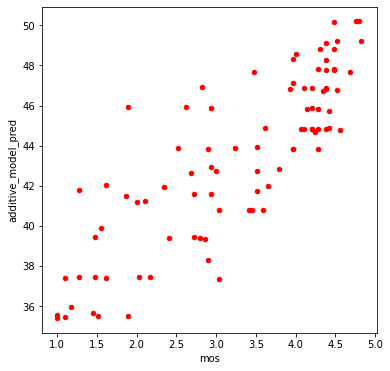

In [31]:
def additive_model(X):
    """X is a dataframe with our features, that we will use, 
    the overall model is just a pure addition of all feature values
    """
    return  X['log_video_bitrate']+X['log_pixel_per_frame']+X['video_codec_num'] 

# as an indicator we will just perform a self-validation for now
dtrain["additive_model_pred"] = additive_model(
    dtrain[["log_video_bitrate", "log_pixel_per_frame", "video_codec_num"]]
)

d(dtrain[["mos", "additive_model_pred"]].head())
# calculate correlations (reuse feature_corr), and do a scatterplot for mos~additive_model_pred
d(feature_corr(dtrain,'mos','additive_model_pred'))  # TBD
 # TBD
dtrain.plot.scatter(x='mos', y='additive_model_pred', c = 'Red');
 

# the additive_model is really stupid, and you could play around with several weights, scale the final score, ..
# however we want to automate this, what leads us to curve fitting, 
#    that is a fundamental hammer to tackle modeling problems

Before we do curve fitting, we want to play around with it, we have been using `curve_fit` already (see SOS `a` parameter).
For the curve fitting checkout the [scipy curve fit example]( https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

estimated coefficients: [   1.63315267 -255.42338166]


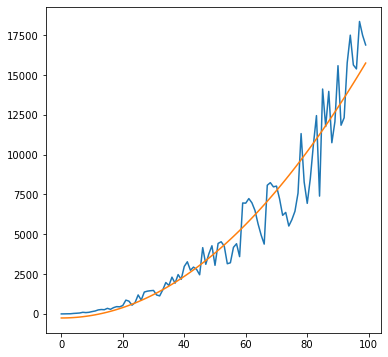

In [32]:
# because this is just a demonstration cell, there are no todos here

# lets create a simple function
x = np.array(range(100))
# a quadratic function with some noise
y = np.array([i * i * np.random.uniform(1,2) + np.random.uniform(0,i) for i in x]) 

# plot function (please dont get confused here, for demonstration we use matplotlib for plotting, 
#   usually data is stored in pandas dataframes, and 
#   it is easier to use pandas plotting methods (that uses matplotlib in the background)
plt.plot(x, y)

# we assume a quadratic function here, so we try to fit it

def q_fun(x, a=1, b=0):
    return a*x*x + b

popt, pcov = curve_fit(q_fun, x, y)
print(f"estimated coefficients: {popt}") 

# we plot the curve fitted function
plt.plot(x, q_fun(x,*popt))

# the results can even be explained, our random values for `a` have been between in [1,2] 
# thus the "mean" is about 1.5
# and the shift `b` was in our data between [0, 100), so something in this range is fine, 
# and the estimated coeffs show this somehow, otherwise run this cell several times, to check the values

estimated coefficients: [-6.54790187e+00  5.11964771e-01 -3.12439246e-03  2.09338548e-02]


<ipython-input-33-6c144e95c13e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtrain["parametric_model_pred"] = parametric_model( dtrain[["log_video_bitrate", "log_pixel_per_frame", "video_codec_num"]],


{'check': 'mos~parametric_model_pred',
 'pearson': 0.8942617437591397,
 'kendall': 0.6986222437053077,
 'spearman': 0.8781884356822106}

<AxesSubplot:xlabel='parametric_model_pred', ylabel='mos'>

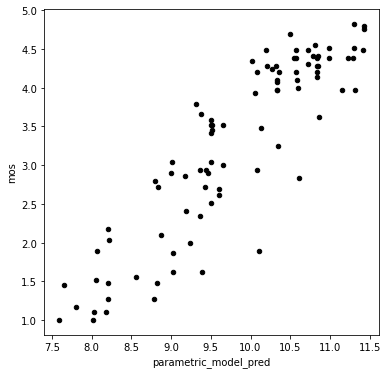

In [33]:
# lets try to do the same for our model

# the function that we want to fit, we assume here some linear connection (due to pearson correlation),
# but we do not know the weights and shift

def parametric_model(X, a=1, b=1, c=1, d=1):
    """ our parametric model, X is a dataframe with the used feature columns
        using curve fitting we want to estimate the parameters a,b,c,d
    """
    return  a + b*X.iloc[:,0] + c*(X.iloc[:,1])**2 + d*(X.iloc[:,2])**3     # TBD

parametric_model_popt, pcov = curve_fit(
    parametric_model,
    dtrain[["log_video_bitrate", "log_pixel_per_frame", "video_codec_num"]],
    dtrain["mos"]
)
print(f"estimated coefficients: {parametric_model_popt}")

# estimate self validated predictions of the trained model
dtrain["parametric_model_pred"] = parametric_model( dtrain[["log_video_bitrate", "log_pixel_per_frame", "video_codec_num"]],
[0],parametric_model_popt[1],parametric_model_popt[2],parametric_model_popt[3]) # TBD
 
d(feature_corr(dtrain, "mos", "parametric_model_pred"))
dtrain.plot(y = "mos", x = "parametric_model_pred",c="black", kind ="scatter")
 
# this model looks already promising, but remember, we haven't done a proper validation, and this is now just
# an indicator of the performance

The last model `rf_model` is a machine learning based model.
In general, a random forest model is a collection of several decision trees (each is trained on a random subset of the data), for more information see [rf model explanation](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d)

Luckily scikit-learn has already a random forest model included, for our task we need the regression variant (because mos is a continuous value), it has been already imported as `RandomForestRegressor` (in the first code cell, for more information check out [scikit-learn RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

<ipython-input-34-75cd76c6bacb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtrain["rf_model_pred"] = cross_val_predict(rf_model, X,Y, cv=10)  # TBD, perform 10 fold cross validation with prediction


{'check': 'mos~rf_model_pred',
 'pearson': 0.8600683116885588,
 'kendall': 0.6847101310971505,
 'spearman': 0.8730407066451027}

<AxesSubplot:xlabel='rf_model_pred', ylabel='mos'>

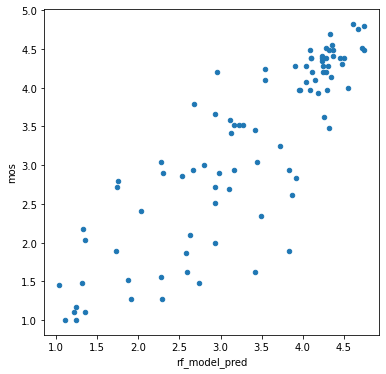

In [34]:
rf_model = RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=0)  # TBD create a RandomForestRegressor model with 20 trees and n_jobs=-1 (for parallel training)

X = dtrain[["log_video_bitrate", "log_pixel_per_frame", "video_codec_num"]]
Y = dtrain["mos"]  # this is our training target

# fit the model with the features and target
rf_model = rf_model.fit(X,Y)  # TBD

# to evaluate the performance of our model, we will not do self-validation as performed before
# the common approach is k-fold-cross-validation (with e.g. k=10)
# luckily scikit-learn has this already included, and it is imported already
# see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html

dtrain["rf_model_pred"] = cross_val_predict(rf_model, X,Y, cv=10)  # TBD, perform 10 fold cross validation with prediction

d(feature_corr(dtrain, "mos", "rf_model_pred"))
dtrain.plot(y="mos", x="rf_model_pred", figsize=(6,6), kind="scatter")

# we can hopefully see, that the RF model is not bad, but a bit worse compared to the parametric_model
# BUT: **important**, this conclusion may be a false indication,
#      because we did 10-fold cross validation for the RF model and self-validation for the others

### Subtask 3.4: Validating the models
After we now developed three different models, we will evaluate them properly using our `dval` dataframe.

We will use:
* correlations (`feature_corr` will be misused)
* root-mean-sqaured-error and
* scatterplots of the predictions

Important here, we will just use the validation data `dval` and the final trained models.
What will be missing in our pipeline is how to deploy such trained models for the final real-world use case.

In [35]:
# select only the validation feature columns
dval_features = dval[["log_video_bitrate", "log_pixel_per_frame", "video_codec_num"]]  # TBD

# store results for each model in the validation dataframe
dval["additive_model_pred"] =  additive_model(dval_features)  # TBD
dval["parametric_model_pred"] = parametric_model(dval_features, parametric_model_popt[0],parametric_model_popt[1],parametric_model_popt[2],parametric_model_popt[3])# TBD
dval["rf_model_pred"] =  cross_val_predict(rf_model, dval_features, dval['mos'], cv=10)

<ipython-input-35-4622c583ac5a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dval["additive_model_pred"] =  additive_model(dval_features)  # TBD
<ipython-input-35-4622c583ac5a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dval["parametric_model_pred"] = parametric_model(dval_features, parametric_model_popt[0],parametric_model_popt[1],parametric_model_popt[2],parametric_model_popt[3])# TBD
<ipython-input-35-4622c583ac5a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [36]:
from sklearn.metrics import mean_squared_error
def rmse(dataframe, column_a, column_b):
    """ calculate rmse of column_a and column_b of the dataframe
    return a dict {
        "rmse": somefunnynumber
    }
    """
    x = dataframe[column_a].tolist()
    y = dataframe[column_b].tolist()
    MSE = np.sqrt(mean_squared_error(x, y))
    return {
        "rmse": MSE   # TBD
    }

assert(rmse(pd.DataFrame({"x":[1,2,3], "y":[1,2,3]}), "x", "y")["rmse"] == 0)
assert(rmse(pd.DataFrame({"x":[1,2,3], "y":[1,2,4]}), "x", "y")["rmse"].round(2) == 0.58)

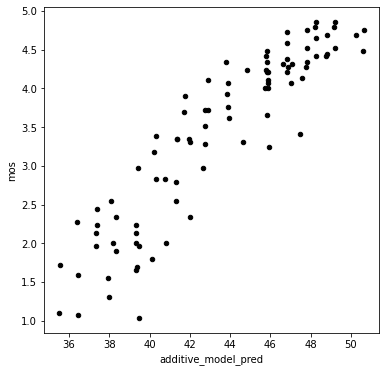

In [37]:
def validation(dval, model_column):
    """a generic method to perform the required validation steps
    
    returns a dict similar to:
    {
        'check': 'mos~additive_model_pred', 
        'pearson': 0.9060022450536154, 
        'kendall': 0.7378407958348552, 
        'spearman': 0.9140890791533999, 
        'rmse': 27.084089299566394
    }
    """
    corr = feature_corr(dval, 'mos', model_column) # TBD calc correlations for mos~"model_column", use `feature_corr` method
    rmse_value = rmse(dval, 'mos', model_column)# TBD calc rmse, use `rmse` method
    dval.plot(y = 'mos', x = model_column,c='black', kind = 'scatter')  # TBD do a correlation plot
   
    return dict(corr, **rmse_value)

assert(set(validation(dval, "additive_model_pred").keys()) == set(["check", "pearson", "kendall", "spearman", "rmse"]))

,check,pearson,kendall,spearman,rmse
2,mos~rf_model_pred,0.905590,0.716784,0.900878,0.467518
1,mos~parametric_model_pred,0.865246,0.678633,0.872282,0.569246
0,mos~additive_model_pred,0.912605,0.748378,0.918757,40.119419


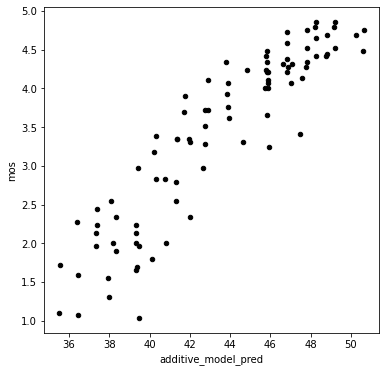

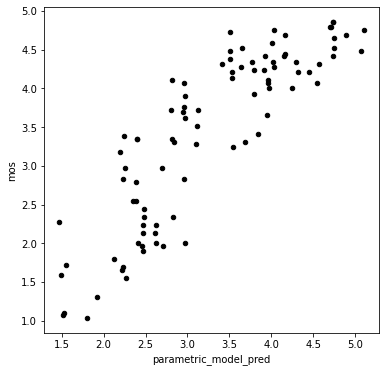

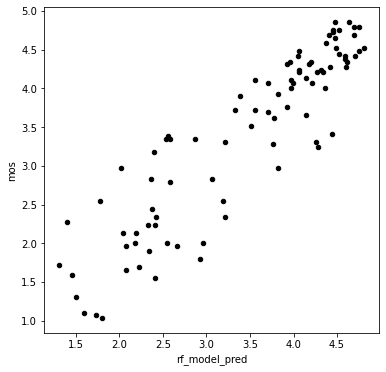

In [38]:
metric_results = pd.DataFrame([
    validation(dval, "additive_model_pred"),
    validation(dval, "parametric_model_pred"),
    validation(dval, "rf_model_pred")
])

d(metric_results.sort_values(by="rmse"))

# so we hopefully see, that even if the additive model is the best considering pearson, it is super bad for RMSE,
# and RMSE would be the metric in a real world application.
# moreover, the rf and parametric models have similar performance,
# the rf model is a bit better than the parametric, but here also both models are just simple models